In [1]:
# from __future__ import division, print_function, with_statement, absolute_import, unicode_literals
import os, sys, numpy as np, pandas as pd, tensorflow as tf, re, codecs, json
import pickle, collections, random, math, numbers, scipy.sparse as sp

def reload(mName):
    import importlib
    if mName in sys.modules:
        del sys.modules[mName]
    return importlib.import_module(mName)

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import mean_squared_error, mean_absolute_error

from math import sqrt
from sklearn.preprocessing import LabelEncoder, minmax_scale
from matplotlib import pyplot as plt
plt.style.use('ggplot')

utils = reload('utils.utils')
np.set_printoptions(precision=4, suppress=True, linewidth=100)

d:\python\anaconda3\envs\py3_6\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<br/>
<br/>
<br/>
## Data Prepare
1. 載入raw data
2. 將user_id, movie_id編碼成index 0 開始的流水號

In [2]:
# 載入raw data
ratings = pd.read_csv("./data/ml-latest-small/ratings.csv")
movies = pd.read_csv("./data/ml-latest-small/movies.csv")
tags = pd.read_csv("./data/ml-latest-small/tags.csv")

# 將user_id, movie_id編碼成index 0 開始的流水號
uidEnc, midEnc = LabelEncoder(), LabelEncoder()
# encode user id and movie id to real value
midEnc.fit(movies.movieId)
uidEnc.fit(ratings.userId)
ratings["userId"] = uidEnc.transform(ratings.userId)
ratings["movieId"] = midEnc.transform(ratings.movieId)
movies["movieId"] = midEnc.transform(movies.movieId)

tags["userId"] = uidEnc.transform(tags.userId)
tags["movieId"] = midEnc.transform(tags.movieId)

midMap = pd.Series(dict(zip(movies.movieId, movies.title)))

nUsers, nMovies = len(uidEnc.classes_), len(midEnc.classes_)
print(ratings.shape)
ratings.head()

(100004, 4)


,userId,movieId,rating,timestamp
0,0,30,2.5,1260759144
1,0,833,3.0,1260759179
2,0,859,3.0,1260759182
3,0,906,2.0,1260759185
4,0,931,4.0,1260759205


In [3]:
# movies profile
movies.head()

,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,Jumanji (1995),Adventure|Children|Fantasy
2,2,Grumpier Old Men (1995),Comedy|Romance
3,3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,4,Father of the Bride Part II (1995),Comedy


In [4]:
# tags profile
tags.head()

,userId,movieId,tag,timestamp
0,14,304,sandra 'boring' bullock,1138537770
1,14,1517,dentist,1193435061
2,14,5166,Cambodia,1170560997
3,14,6118,Russian,1170626366
4,14,6178,forgettable,1141391765


<br/>
<br/>
<br/>
### Split Train and Test Data, Making Rating Matrix

+ 已經產生出檔案的不用跑這一段

In [5]:
# # 已經產生出檔案的不用跑這一段
# tr, te = utils.split_ratings(ratings, testRatio=0.3)
# tr.to_csv("./data/ml-latest-small/movielens.tr.csv", index=False)
# te.to_csv("./data/ml-latest-small/movielens.te.csv", index=False)
# utils.dumpPickle("./data/ml-latest-small/state.h", 
#         {"uidEnc": uidEnc, "midEnc": midEnc, "midMap": midMap, "nUsers": nUsers, "nMovies":nMovies})

In [6]:
tr = pd.read_csv("./data/ml-latest-small/movielens.tr.csv")
te = pd.read_csv("./data/ml-latest-small/movielens.te.csv")

# state = utils.loadPickle("./data/ml-latest-small/state.h")
# uidEnc, midEnc, midMap, nUsers, nMovies = \
#     (state["uidEnc"], state["midEnc"], state["midMap"], state["nUsers"], state["nMovies"])

# train data rating matrix
trRatingMat = np.zeros((nUsers, nMovies))
# test data rating matrix
teRatingMat = np.zeros((nUsers, nMovies))
for idx, r in tr.iterrows():
    trRatingMat[int(r.userId), int(r.movieId)] = r.rating
for idx, r in te.iterrows():
    teRatingMat[int(r.userId), int(r.movieId)] = r.rating

print("number of users: ", trRatingMat.shape[0], "number of items: ", trRatingMat.shape[1])
print("train interaction matrix shape: ", trRatingMat.shape, "test interaction matrix shape: ", teRatingMat.shape)
print("train.shape: ", tr.shape, "test.shape: ", te.shape)
print()
print(tr.head())
print()
print(te.head())

number of users:  671 number of items:  9125
train interaction matrix shape:  (671, 9125) test interaction matrix shape:  (671, 9125)
train.shape:  (69399, 4) test.shape:  (30605, 4)

   userId  movieId  rating   timestamp
0       0      931     4.0  1260759205
1       0     1515     4.0  1260759191
2       0       30     2.5  1260759144
3       0      833     3.0  1260759179
4       0      859     3.0  1260759182

   userId  movieId  rating   timestamp
0       0     1665     4.0  1260759139
1       0     1708     3.0  1260759194
2       0     1743     2.0  1260759198
3       0     1815     2.0  1260759108
4       0     1962     2.5  1260759113


## Observations
```
1. user數量遠小於item數量, 這是很常見的狀態
2. user attributes與item attributes非常少
```

<br/>
<br/>
<br/>
## Similarity 運作方式

![Alt text](./similarity.jpg)

#### Cosine 相似度

In [7]:
uid = 66
simMat = cosine_similarity([trRatingMat[uid]], trRatingMat)
# 找出Top 5和自己rating狀況最像的人
print(simMat.ravel().argsort()[::-1][:5])

[ 66 601 547 658 171]


#### Euclidean 相似度

In [8]:
def euclidean_similarity(*args, **kwargs):
    r = euclidean_distances(*args, **kwargs)
    return 1 - r / np.max(r)

uid = 66
simMat = euclidean_similarity([trRatingMat[uid]], trRatingMat)
# 找出Top 5和自己rating狀況最像的人
simMat.ravel().argsort()[::-1][:5]

array([ 66, 171, 107, 628, 121], dtype=int64)

#### 一次算出所有user之間的相似度
1. 對稱矩陣
2. 對角線(自己和自己的相似度為1)
3. 注意user人數過多容易爆記憶體

In [9]:
simMat = cosine_similarity(trRatingMat)
print("shape of user similarity matrix: ", simMat.shape)
simMat

shape of user similarity matrix:  (671, 671)


array([[1.    , 0.    , 0.    , ..., 0.0923, 0.    , 0.    ],
       [0.    , 1.    , 0.1038, ..., 0.0354, 0.1438, 0.0638],
       [0.    , 0.1038, 1.    , ..., 0.0516, 0.1723, 0.1891],
       ...,
       [0.0923, 0.0354, 0.0516, ..., 1.    , 0.    , 0.0904],
       [0.    , 0.1438, 0.1723, ..., 0.    , 1.    , 0.227 ],
       [0.    , 0.0638, 0.1891, ..., 0.0904, 0.227 , 1.    ]])

<br/>
<br/>
<br/>
## Memory Based Collaborative Filter 物件
Functions
1. fit: training, 這裡只是簡單set rating matrix
2. predict: 產出指定user對於所有items的評分
3. evaluateRMSE: 計算平方誤差
4. evaluateMAE: 計算絕對值誤差
(evaluateRMSE, evaluateMAE選用其一即可)

In [10]:
class MemoryBaseCF(object):
    """使用Collaborative Filtering演算法"""
    def __init__(self):
        self.ratings = None
        
    def fit(self, ratings):
        """紀錄ratings (interaction matrix between users and items)"""
        self.ratings = ratings
        return self
    
    def predict(self, users:list, simFn=cosine_similarity, tpe="user"):
        """定義以下變數
        user_sim = similarity with other users
        item_sim = similarity with other items
        ratings = all user ratings on this items
        
        分別是user base CF與item base CF的算法
        user base CF: item score = user_sim dot ratings / sum of user_sim
        item base CF: item score = ratings dot item_sim / sum of item_sim
        """
        return predict(self, users, simFn=cosine_similarity, tpe=tpe)
    
    def evaluateRMSE(self, inputs, tpe="user", nBatch=500):
        """計算root mean square error, 不包含interaction matrix = 0的部分"""
        return evaluateRMSE(self, inputs, tpe, nBatch)
    
    def evaluateMAE(self, inputs, tpe="user", nBatch=500):
        """計算 mean absolutely error, 不包含interaction matrix = 0的部分"""
        return evaluateMAE(self, inputs, tpe, nBatch)

<br/>
<br/>
<br/>
## Prediction: 計算加權平均數
$$ r_{ij} \leftarrow \frac{\sum_i(w_i \cdot r_{ij})}{\sum_{i, \text{where} \space r_{ij}\neq 0} w_i} $$
![Alt text](./weighted_avg.jpg)

In [11]:
def predict(self, users:list, simFn=cosine_similarity, tpe="user"):
    """定義以下變數
    user_sim = similarity with other users
    item_sim = similarity with other items
    ratings = all user ratings on this items

    分別是user base CF與item base CF的算法
    user base CF: item score = user_sim dot ratings / sum of user_sim
    item base CF: item score = ratings dot item_sim / sum of item_sim
    """
    if tpe == "user":
        # shape of inputUserRate is len(users) * nItems
        inputUserRate = self.ratings[users]
        # shape of sim is [len(users) * nUsers]
        sim = simFn(inputUserRate, self.ratings)
        # shape of dot is [len(users) * nItems]
        dot = sim.dot(self.ratings)
        # dot = sim.dot(self.ratingsDiff)

        # mask 對於此item沒有rating的項目
        # shape of simSum is [len(users) * nItems]
        simSum = sim.dot(self.ratings != 0) # simSum = sim.dot(np.ones_like(self.ratings))

        ret = np.zeros_like(dot)
        # item rating = ((user similarity) dot product (all user rating to this item)) / masked sum of user similarity
        for user in np.arange(dot.shape[0]):
            for item in np.arange(dot.shape[1]):
                # maskedSimSum = np.sum(singleUserSim * (self.ratings[:, item] != 0))
                ret[user, item] = (dot[user, item] / simSum[user, item]) if simSum[user, item] != 0 else 0
        return np.clip(ret, 1, 5)
        # return np.clip(self.meanRating[users] + ret, 0, 5)
    elif tpe == "item":
        # shape of inputUserRate is len(users) * nItems
        inputUserRate = self.ratings[users]
        # shape of sim is [nItems * nItems]
        sim = simFn(self.ratings.T)
        # shape of dot is [len(users) * nItems]
        dot = inputUserRate.dot(sim)
        # mask 對於此item沒有rating的項目
        # shape of simSum is [nUsers * nItems]
        simSum = (self.ratings != 0).dot(sim)
        ret = np.zeros_like(dot)
        # item rating = ((single user rating to this item) dot product (item similarity)) / masked sum of item similarity
        for user in np.arange(dot.shape[0]):
            for item in np.arange(dot.shape[1]):
                # simSum = denom[item]
                ret[user, item] = (dot[user, item] / simSum[user, item]) if simSum[user, item] != 0 else 0
        return np.clip(ret, 1, 5)

## RMSE
$$ \sqrt{\sum_i(Pred_i - True_i)^2} $$
## MAE
$$ \sum_i \left| Pred_i - True_i \right| $$

In [12]:
def evaluateRMSE(self, inputs, tpe="user", nBatch=500):
    """計算root mean square error, 不包含interaction matrix = 0的部分"""
    loss = 0
    users = np.arange(self.ratings.shape[0])
    for startPos in range(0, self.ratings.shape[0], nBatch):
        batchUsers = users[startPos : startPos + nBatch]
        bRatings = self.predict(batchUsers, tpe=tpe)
        loss += rmse(bRatings, inputs[startPos : startPos + nBatch]) ** 2 * len(batchUsers)
    return math.sqrt(loss / len(users))

def evaluateMAE(self, inputs, tpe="user", nBatch=500):
    """計算 mean absolutely error, 不包含interaction matrix = 0的部分"""
    loss = 0
    users = np.arange(self.ratings.shape[0])
    for startPos in range(0, self.ratings.shape[0], nBatch):
        batchUsers = users[startPos : startPos + nBatch]
        bRatings = self.predict(batchUsers, tpe=tpe)
        loss += mae(bRatings, inputs[startPos : startPos + nBatch]) * len(batchUsers)
    return loss / len(users)

def rmse(prediction, ground_truth):
    """計算squared error的時候會mask掉ground_truth為0的部分"""
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return math.sqrt(mean_squared_error(prediction, ground_truth))

def mae(prediction, ground_truth):
    """計算absolute error的時候會mask掉ground_truth為0的部分"""
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return mean_absolute_error(prediction, ground_truth)

## Training

In [13]:
# fitting model
model = MemoryBaseCF()
model.fit(trRatingMat)

## Predict (回傳單一User對所有Items的分數)

In [14]:
uid = 66
model.predict([uid]) # array([[ 3.8833,  3.4444,  3.1242, ...,  1.    ,  1.    ,  1.    ]])

array([[3.8833, 3.4444, 3.1242, ..., 1.    , 1.    , 1.    ]])

<br/>
<br/>
<br/>
## evaluate model 

In [15]:
%%time
print("user base Collaborative Filtering MAE loss: ", model.evaluateMAE(teRatingMat, tpe="user"))
print("user base Collaborative Filtering RMSE loss: ", model.evaluateRMSE(teRatingMat, tpe="user"))

user base Collaborative Filtering MAE loss:  1.1156171786971176
user base Collaborative Filtering RMSE loss:  1.4730915195266507
Wall time: 24 s


In [16]:
%%time
print("item base Collaborative Filtering MAE loss: ", model.evaluateMAE(teRatingMat, tpe="item"))
print("item base Collaborative Filtering RMSE loss: ", model.evaluateRMSE(teRatingMat, tpe="item"))

item base Collaborative Filtering MAE loss:  1.1693025708268519
item base Collaborative Filtering RMSE loss:  1.554707314100659
Wall time: 36.3 s


<br/>
<br/>
<br/>
### 發現以Item Base去推薦分數不太好, 檢查 Train Data Sparsity:

In [21]:
print( "{} users didn't rate any movie!".format((trRatingMat.sum(axis=1) == 0).sum()) )
print( "{} movies are not rated!".format((trRatingMat.sum(axis=0) == 0).sum()) )

0 users didn't rate any movie!
3164 movies are not rated!


<br/>
<br/>
<br/>
### Model Evaluation

### 單一user rating分布圖

shape:  (9125,) [3.8319 3.2478 2.7913 ... 1.     1.     1.    ]


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


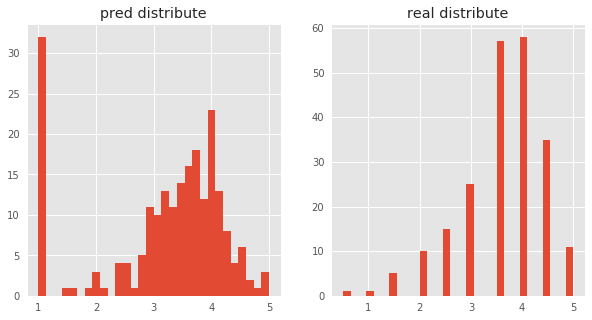

In [23]:
# valid user id from 0 ~ 670
uid = 22
pred = model.predict([uid]).ravel()
print("shape: ", pred.shape, pred)

nnzCoord = teRatingMat[uid].nonzero()
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("pred distribute")
pd.Series(pred.ravel()[nnzCoord]).hist(bins=30, ax=ax[0])
ax[1].set_title("real distribute")
pd.Series(map(lambda e: e, teRatingMat[uid][nnzCoord])).hist(bins=30, ax=ax[1])
plt.show()

<br/>
<br/>
<br/>
## Evaluate Model

#### User導向評估(Recall)

In [24]:
# 可給定user id細看每個user的rating與model預測效果
# valid user id from 0 ~ 670
uid = 22
recomm = model.predict([uid]).ravel()
recommDf = pd.DataFrame(data={
              "userId": uid,
              "movieId": range(len(recomm)),
              "title": midMap[np.arange(len(recomm))].values,
              "rating": teRatingMat[uid, range(len(recomm))],
              "predRating": recomm},
             columns=("userId", "movieId", "title", "rating", "predRating"))
# ascending 可以調整True or False觀察結果
recommDf.query("rating != 0").sort_values("rating", ascending=False).head(50)

,userId,movieId,title,rating,predRating
4417,22,4417,Catch Me If You Can (2002),5.0,3.770959
5623,22,5623,Undertow (2004),5.0,1.000000
4419,22,4419,"Hours, The (2002)",5.0,3.367638
4432,22,4432,City of God (Cidade de Deus) (2002),5.0,4.162015
4371,22,4371,Adaptation (2002),5.0,4.156001
4008,22,4008,And Your Mother Too (Y tu mamá también) (2001),5.0,3.519416
6132,22,6132,Crash (2004),5.0,3.689451
5016,22,5016,Stolen Kisses (Baisers volés) (1968),5.0,4.000000
5761,22,5761,Duel (1971),5.0,4.000000
4875,22,4875,"Unvanquished, The (Aparajito) (1957)",5.0,1.000000


#### Model導向評估(Precision)

In [25]:
print("recommend for user {}".format(uid))
recommDf.query("rating != 0").sort_values("predRating", ascending=False)

recommend for user 22


,userId,movieId,title,rating,predRating
4910,22,4910,"Passion of Joan of Arc, The (Passion de Jeanne...",4.0,5.000000
4751,22,4751,Ikiru (1952),4.0,5.000000
5369,22,5369,Viridiana (1961),3.5,4.872026
6167,22,6167,"Edukators, The (Die Fetten Jahre sind vorbei) ...",3.5,4.777850
4109,22,4109,"Last Waltz, The (1978)",3.5,4.660428
3957,22,3957,"Bad and the Beautiful, The (1952)",4.0,4.611701
5347,22,5347,"Dolce Vita, La (1960)",3.5,4.512228
4529,22,4529,Europa Europa (Hitlerjunge Salomon) (1990),4.0,4.511510
4738,22,4738,Code Unknown (Code inconnu: Récit incomplet de...,2.5,4.500000
5495,22,5495,"Short Film About Killing, A (Krótki film o zab...",2.5,4.500000


### Precision At K (K = 10)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


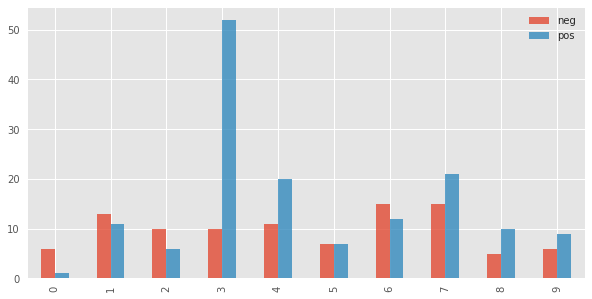

In [26]:
pos_ary, neg_ary = [], []
for label in teRatingMat:
    label = label[label != 0]
    pos_ary.append(sum(label >= 4))
    neg_ary.append(sum(label < 4))
    # print("pos: {}, neg: {}".format(sum(label >= 4), sum(label < 4)))
    
def draw_pos_neg(idx):
    pd.DataFrame(
        index=idx,
        data={"pos": np.array(pos_ary)[idx], "neg": np.array(neg_ary)[idx]}).plot.bar(figsize=(10, 5), alpha=0.8)
    plt.show()

draw_pos_neg(np.arange(len(teRatingMat))[0:10])

### About Test Data Movie Ratings(觀察上圖)
```
1. 0號, 2號, 5號, 9號 user 正向評價數量 < 10, 就算model全部預測命中, 命中率也不會是 100%!
   ex: 0號user只有1個正向評價, 全部命中也指得到0.1的分數
2. 3號user正向評價是負向評價的5倍多, 就算亂猜, 中的機率也很高
```

In [17]:
_ = sum(np.sum(teRatingMat >= 4, 1) < 10)
print("{} 個user正向評價總數小於10!".format(_))

266 個user正向評價總數小於10!


In [33]:
def strict_condition(label):
    label = label[label != 0]
    pos, neg = sum(label >= 4), sum(label < 4)
    return len(label) >= 10 and pos <= neg and pos > 0
    
print("test data中, rating數量 >= 10 且 負評價數量 >= 正評價數量 有 [{}] 人".format(sum(strict_condition(label) for label in teRatingMat)))

def norm_condition(label):
    label = label[label != 0]
    return sum(label >= 4) > 0 and sum(label < 4) > 0

print("test data中, rating正評價數量 >= 0 且 rating負評價數量 >= 0 有 [{}] 人".format(sum(norm_condition(label) for label in teRatingMat)))

test data中, rating數量 >= 10 且 負評價數量 >= 正評價數量 有 [209] 人
test data中, rating正評價數量 >= 0 且 rating負評價數量 >= 0 有 [669] 人


#### Precision At K: 
> **預測分數高(rating >= 4)的前10部電影, 和實際user rating比較, 觀察命中率**

In [46]:
%%time
from sklearn.metrics import precision_score

def precision_at_k(truth, pred_mat, condition_fn=None, k=10, label_thres=4):
    hits, total = 0, 0
    for label, pr in zip(truth, pred_mat):
        if not condition_fn(label): continue

        top_k_ind = (pr * (label != 0)).argsort()[::-1][:k]
        hits += sum(label[top_k_ind] >= label_thres)
        total += k
    return hits / total

pred_mat= []
users = np.arange(nUsers)
for pos in range(0, nUsers, 200):
    batch = users[pos:pos + 200]
    pred_mat.append(model.predict(batch, simFn=cosine_similarity))
pred_mat = np.vstack(pred_mat)

print( "strict condition precision at 10: ", precision_at_k(teRatingMat, pred_mat, strict_condition, k=10) )
print( "norm condition precision at 10: ", precision_at_k(teRatingMat, pred_mat, norm_condition, k=10) )

strict condition precision at 10:  0.5057416267942584
norm condition precision at 10:  0.6312406576980568
Wall time: 6.42 s


### NDCG: Normalized Discounted Cumulative Gain
1. A measure of ranking quality.
2. loop 每一位user, prediciton score排序後計算NDCG
    <br/>$$ DCG_p = \sum^p_{i = 1} \frac{2^{rel_i} - 1}{log_2(i + 1)} $$<br/>
3. IDCG: Ideal DCG, 為理想狀態下的DCG分數, 即model全部命中的DCG分數, 而NDCG: Normalized DCG, 公式如下
    <br/>$$ NDCG_p = \sum^p_{i = 1} \frac{DCG_p}{IDCG_p} $$<br/>
4. 所以NDCG是一個比值, 介於0 ~ 1之間

In [20]:
def single_user_ndcg(label, score, label_thres=4, k=10):
    """single user ndcg score"""
    nnz = label.nonzero()[0]
    # if np.sum(label >= label_thres) < k: return None
    label, score = label[nnz], score[nnz]
    label = (label >= label_thres).astype(int)
    return utils.ndcg_score(label, score, k)

def all_user_ndcg(label_mat, pred_mat, cond_fn, label_thres=4, k=10):
    """avg of all user ndcg score"""
    tot_ndcg, actual_cnt = 0, 0
    for i, (label, score) in enumerate(zip(label_mat, pred_mat)):
        if not cond_fn(label): continue

        ndcg = single_user_ndcg(label, score, k=10)
        if ndcg is not None:
            tot_ndcg += ndcg
            actual_cnt += 1
    return tot_ndcg / actual_cnt

pred_mat = []
for pos in range(0, nUsers, 200):
    batch = users[pos:pos + 200]
    pred_mat.append(model.predict(batch, simFn=cosine_similarity))
pred_mat = np.vstack(pred_mat)
    
strict_ndcg = all_user_ndcg(teRatingMat, pred_mat, strict_condition, label_thres=4, k=10)
norm_ndcg = all_user_ndcg(teRatingMat, pred_mat, norm_condition, label_thres=4, k=10)
print("strict condition ndcg at 10: ", strict_ndcg)
print("norm condition ndcg at 10: ", norm_ndcg)

strict condition ndcg at 10:  0.609228658824
norm condition ndcg at 10:  0.752621640898


### ROC_CURVE (Receiver operating characteristic), AUC (Area Under Curve)
TP Rate cross FP Rate, 觀察curve的變化
1. AUC = 0.5 (no discrimination 無鑑別力)
2. 0.7 ≦ AUC ≦ 0.8 (acceptable discrimination 可接受的鑑別力)
3. 0.8 ≦ AUC ≦ 0.9 (excellent discrimination 優良的鑑別力)
4. 0.9 ≦ AUC ≦ 1.0 (outstanding discrimination 極佳的鑑別力)

auc: 0.6293958936986446


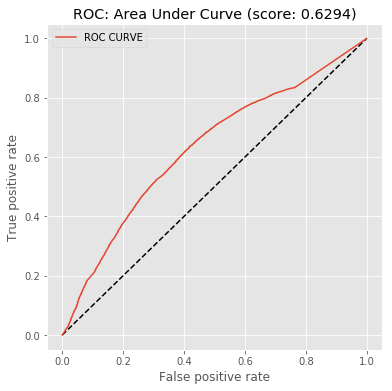

In [17]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

def drawRocCurve(y, predProba):
    fprRf, tprRf, _ = roc_curve(y, predProba, pos_label=1)
    aucScr = auc(fprRf, tprRf)
    print("auc:", aucScr)
    f, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fprRf, tprRf, label='ROC CURVE')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('ROC: Area Under Curve (score: {:.4f})'.format(aucScr))
    ax.legend(loc='best')
    plt.show()
    
# 只看非0的部分
coord = teRatingMat.nonzero()
predMat = model.predict(np.arange(teRatingMat.shape[0]).tolist(), tpe="user")
# regard rating >= 4 as user like this movie
drawRocCurve((teRatingMat[coord] >= 4).astype(int), predMat[coord])

<br/>
<br/>
<br/>
## Baseline: 不經過訓練隨機產生預測值

auc: 0.4964233079342529


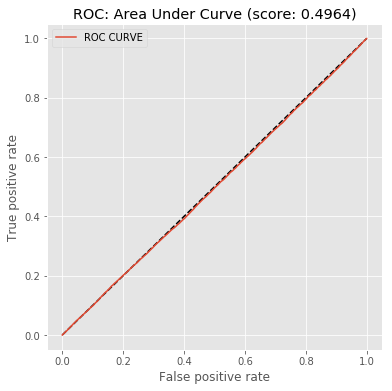

In [19]:
dummyPredMat = np.random.random((nUsers, nMovies))
drawRocCurve((teRatingMat >= 4).astype(int).ravel(), dummyPredMat.ravel())

+ 不經過訓練隨機產生預測值 precision at 10

In [47]:
print( "strict condition precision at 10: ", precision_at_k(teRatingMat, dummyPredMat, strict_condition, k=10) )
print( "norm condition precision at 10: ", precision_at_k(teRatingMat, dummyPredMat, norm_condition, k=10) )

strict condition precision at 10:  0.3751196172248804
norm condition precision at 10:  0.5414050822122571


+ 不經過訓練隨機產生預測值 ndcg at 10

In [25]:
strict_ndcg = all_user_ndcg(label, dummyPredMat, strict_condition, label_thres=4, k=10)
norm_ndcg = all_user_ndcg(label, dummyPredMat, norm_condition, label_thres=4, k=10)
print("strict condition ndcg at 10: ", strict_ndcg)
print("norm condition ndcg at 10: ", norm_ndcg)

strict condition ndcg at 10:  0.455902044569
norm condition ndcg at 10:  0.637114073086


<br/>
<br/>
<br/>
## Concept
1. MAE, RMSE, 是最基本拿來評估的指標, Netflix競賽指標就是以RMSE為指標
2. AUC(ROC) => TP Rate cross FP Rate, 觀察curve的變化
    + AUC = 0.5 (no discrimination 無鑑別力)
    + 0.7 ≦ AUC ≦ 0.8 (acceptable discrimination 可接受的鑑別力)
    + 0.8 ≦ AUC ≦ 0.9 (excellent discrimination 優良的鑑別力)
    + 0.9 ≦ AUC ≦ 1.0 (outstanding discrimination 極佳的鑑別力)
3. NDCG rank sensitive的指標, recommendation可視為ranking problem. ex: 跟主題相關的item擺在第1位的分數, 
    與擺在第5位的分數相比, 前者分數較高
4. precision at k與recall at k的部分以recommendation來說會較注重precision, 因為recall需要得知user所有偏愛的items, 而這個資訊通常無法得知